In [96]:
import os
import pandas as pd
import numpy as np
import anndata as ad
import scipy
import torch
import umap
import time as t
import random
from itertools import product
import concurrent.futures
from sklearn.neighbors import NearestNeighbors
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc

In [139]:
## Load real and generated scRNA-seq data
'''
- Load real and generated expression matrices.
- Cells as rows and genes as columns

specify PATH's to real and generated expression matrices in h5 format

'''
run_dir = "/Users/guyshani/Documents/PHD/Aim_2/test_models/full_data_counts/run_20250302_091205_dataset+myannotations/"
data_path = "/Users/guyshani/Documents/PHD/Aim_2/PBMC_data/mouse/"

df_real = ad.read_h5ad(os.path.join(data_path, "test_data_library_counts_PBMC.h5ad"))
df_real = df_real.X.toarray()

df_gen = ad.read_h5ad(os.path.join(run_dir, "generated_data.h5ad"))
df_gen = df_gen.X

# test that both matrices have the same size
print("x_test shape:", df_real.shape)
print("x_gen shape:", df_gen.shape)

x_test shape: (11854, 18445)
x_gen shape: (11854, 18445)


In [94]:
## Correlation matrix calculations
def upper_diag_list(m_):
   """Returns upper triangular values of matrix, excluding diagonal"""
   # np.triu_indices gets indices of upper triangle, k=1 excludes diagonal
   return m_[np.triu_indices(len(m_), k=1)]

def standardize(a):
    """Standardizes data by subtracting mean and dividing by std dev (z-score)"""
    a_off = np.mean(a, axis=0)  # Calculate mean
    a_std = np.std(a, axis=0)   # Calculate standard deviation
    S = (a - a_off) / a_std     # Z-score standardization
    S[np.isnan(S)] = (a - a_off)[np.isnan(S)]  # Handle zeros in std
    return S
def pearson_correlation(x: np.array, y: np.array):
    """Computes correlation between each pair of vectors in x and y matrices"""
    assert x.shape[0] == y.shape[0] # Check input matrices have same number of samples
    x_ = standardize(x)
    y_ = standardize(y)
    return np.dot(x_.T, y_) / x.shape[0]  # Compute correlation as dot product of standardized values

def correlations_list(x: np.array, y: np.array):
    """Gets list of correlations between all pairs"""
    corr = pearson_correlation(x, y)
    return upper_diag_list(corr)

def gamma_coeff_score(x_test: np.array, x_gen: np.array):
    """Calculates correlation between distance matrices of test and generated data"""
    assert x_test.shape[1] == x_gen.shape[1]    # Verify matrices have same number of features
    dists_x = 1 - correlations_list(x_test, x_test)
    dists_y = 1 - correlations_list(x_gen, x_gen)
    # Reshape for pearson_correlation, to column vectors and compute correlation between distances
    return pearson_correlation(dists_x.reshape(-1, 1), dists_y.reshape(-1, 1))

In [140]:
# pearson correlation between correlation matrices
g = gamma_coeff_score(df_real, df_gen)
g

/var/folders/g_/c_f20pc566n31j9p36lcdc0w0000gn/T/ipykernel_31084/1680201818.py:11: RuntimeWarning: invalid value encountered in divide
  S = (a - a_off) / a_std     # Z-score standardization


array([[0.13984314]], dtype=float32)

In [102]:
# SEED
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
np.random.seed(42)
random.seed(42)

In [103]:
def batch_pairwise_distances(U: torch.tensor, V: torch.tensor):
    """Compute pairwise distances between two batches of feature vectors.
    ----
    Parameters:
        U (torch.tensor): first feature vector
        V (torch.tensor): second feature vector
    Returns:
        tensor of pairwise distances """

    # Squared norms of each row in U and V.
    norm_u = torch.sum(torch.square(U), 1)
    norm_v = torch.sum(torch.square(V), 1)

    # norm_u as a column and norm_v as a row vectors.
    norm_u = torch.reshape(norm_u, (-1, 1))
    norm_v = torch.reshape(norm_v, (1, -1))

    # Pairwise squared Euclidean distances.
    D = torch.maximum(norm_u - 2 * torch.matmul(U, V.T) +
                      norm_v, torch.zeros((1,)))

    return D


class ManifoldEstimator():
    """Estimates the manifold of given feature vectors."""

    def __init__(self, features, row_batch_size=25000, col_batch_size=50000,
                 nhood_sizes=[3], clamp_to_percentile=None, eps=1e-5):
        """Estimate the manifold of given feature vectors.

            Args:
                features (np.array/tf.Tensor): Matrix of feature vectors to estimate their manifold.
                row_batch_size (int): Row batch size to compute pairwise distances
                    (parameter to trade-off between memory usage and performance).
                col_batch_size (int): Column batch size to compute pairwise distances.
                nhood_sizes (list): Number of neighbors used to estimate the manifold.
                clamp_to_percentile (float): Prune hyperspheres that have radius larger than
                    the given percentile.
                eps (float): Small number for numerical stability.
        """
        batch_size = features.shape[0]
        self.nhood_sizes = nhood_sizes
        self.num_nhoods = len(nhood_sizes)
        self.eps = eps
        self.row_batch_size = row_batch_size
        self.col_batch_size = col_batch_size
        self._ref_features = features

        # Estimate manifold of features by calculating distances to k-NN of
        # each sample.
        self.D = np.zeros([batch_size, self.num_nhoods], dtype=np.float32)
        distance_batch = np.zeros(
            [row_batch_size, batch_size], dtype=np.float32)
        seq = np.arange(max(self.nhood_sizes) + 1, dtype=np.int32)

        for begin1 in range(0, batch_size, row_batch_size):
            end1 = min(begin1 + row_batch_size, batch_size)
            row_batch = features[begin1:end1]

            for begin2 in range(0, batch_size, col_batch_size):
                end2 = min(begin2 + col_batch_size, batch_size)
                col_batch = features[begin2:end2]

                # Compute distances between batches.
                distance_batch[0:end1 - begin1,
                               begin2:end2] = batch_pairwise_distances(row_batch,
                                                                       col_batch)

            # Find the k-nearest neighbor from the current batch.
            self.D[begin1:end1, :] = np.partition(
                distance_batch[0:end1 - begin1, :], seq, axis=1)[:, self.nhood_sizes]

        if clamp_to_percentile is not None:
            max_distances = np.percentile(self.D, clamp_to_percentile, axis=0)
            self.D[self.D > max_distances] = 0

    def evaluate(
            self,
            eval_features,
            return_realism=False,
            return_neighbors=False):
        """Evaluate if new feature vectors are at the manifold.
        """
        num_eval = eval_features.shape[0]
        num_ref = self.D.shape[0]
        distance_batch = np.zeros(
            [self.row_batch_size, num_ref], dtype=np.float32)
        batch_predictions = np.zeros(
            [num_eval, self.num_nhoods], dtype=np.int32)
        max_realism_score = np.zeros([num_eval,], dtype=np.float32)
        nearest_indices = np.zeros([num_eval,], dtype=np.int32)

        for begin1 in range(0, num_eval, self.row_batch_size):
            end1 = min(begin1 + self.row_batch_size, num_eval)
            feature_batch = eval_features[begin1:end1]

            for begin2 in range(0, num_ref, self.col_batch_size):
                end2 = min(begin2 + self.col_batch_size, num_ref)
                ref_batch = self._ref_features[begin2:end2]

                distance_batch[0:end1 - begin1,
                               begin2:end2] = batch_pairwise_distances(feature_batch,
                                                                       ref_batch)

            # From the minibatch of new feature vectors, determine if they are in the estimated manifold.
            # If a feature vector is inside a hypersphere of some reference sample, then
            # the new sample lies at the estimated manifold.
            # The radii of the hyperspheres are determined from distances of
            # neighborhood size k.
            samples_in_manifold = distance_batch[0:end1 -
                                                 begin1, :, None] <= self.D
            batch_predictions[begin1:end1] = np.any(
                samples_in_manifold, axis=1).astype(np.int32)

            max_realism_score[begin1:end1] = np.max(
                self.D[:, 0] / (distance_batch[0:end1 - begin1, :] + self.eps), axis=1)
            nearest_indices[begin1:end1] = np.argmin(
                distance_batch[0:end1 - begin1, :], axis=1)

        if return_realism and return_neighbors:
            return batch_predictions, max_realism_score, nearest_indices
        elif return_realism:
            return batch_predictions, max_realism_score
        elif return_neighbors:
            return batch_predictions, nearest_indices

        return batch_predictions


def knn_precision_recall_features(
        ref_features,
        eval_features,
        nhood_sizes=[3],
        row_batch_size=10000,
        col_batch_size=50000,
        num_gpus=1):
    """Calculates k-NN precision and recall for two sets of feature vectors.

        Args:
            ref_features (np.array/tf.Tensor): Feature vectors of reference samples.
            eval_features (np.array/tf.Tensor): Feature vectors of generated samples.
            nhood_sizes (list): Number of neighbors used to estimate the manifold.
            row_batch_size (int): Row batch size to compute pairwise distances
                (parameter to trade-off between memory usage and performance).
            col_batch_size (int): Column batch size to compute pairwise distances.
            num_gpus (int): Number of GPUs used to evaluate precision and recall.
        Returns:
            State (dict): Dict that contains precision and recall calculated from
            ref_features and eval_features.
    """
    state = dict()
    num_data = ref_features.shape[0]
    num_features = ref_features.shape[1]

    # Initialize ManifoldEstimators.
    ref_manifold = ManifoldEstimator(
        ref_features,
        row_batch_size,
        col_batch_size,
        nhood_sizes)
    eval_manifold = ManifoldEstimator(
        eval_features,
        row_batch_size,
        col_batch_size,
        nhood_sizes)

    # Evaluate precision and recall using k-nearest neighbors.
    #print('Evaluating k-NN precision and recall with %i samples...' % num_data)
    start = t.time()

    # Precision: How many points from eval_features are in ref_features
    # manifold.
    precision = ref_manifold.evaluate(eval_features)
    state['precision'] = precision.mean(axis=0)

    # Recall: How many points from ref_features are in eval_features manifold.
    recall = eval_manifold.evaluate(ref_features)
    state['recall'] = recall.mean(axis=0)

    #print('Evaluated k-NN precision and recall in: %gs' % (t.time() - start))

    return state


def get_precision_recall(
        real_data: torch.tensor,
        fake_data: torch.tensor,
        nb_nn: list = [50]):
    """
    Compute precision and recall between datasets.
    ----
    Parameters:
        real_data (torch.tensor): First data set of comparison.
        fake_data (torch.tensor): Second dataset to use for comparison.
        nb_nn (list): Number of neighbors used to estimate the data manifold.
    Returns:
        tuple with precision and recall.
    """

    # Calculate k-NN precision and recall.
    state = knn_precision_recall_features(
        real_data, fake_data, nhood_sizes=nb_nn)

    precision = state['precision'][0]
    recall = state['recall'][0]

    return (precision, recall)


def get_realism_score(real_data: torch.tensor, fake_data: torch.tensor):
    """
    Compute realism score between datasets.
    ----
    Parameters:
        real_data (torch.tensor): First data set of comparison.
        fake_data (torch.tensor): Second dataset to use for comparison.
    Returns:
        Maximum realism score.
    """

    # Estimate manifold of real images.
    print('Estimating manifold of real data...')
    real_manifold = ManifoldEstimator(real_data, clamp_to_percentile=50)

    # Estimate quality of individual samples.
    _, realism_scores = real_manifold.evaluate(fake_data, return_realism=True)

    return realism_scores

In [141]:
rc = get_realism_score(torch.tensor(df_real), torch.tensor(df_gen))
pr = get_precision_recall(torch.tensor(df_real), torch.tensor(df_gen))

Estimating manifold of real data...


/var/folders/g_/c_f20pc566n31j9p36lcdc0w0000gn/T/ipykernel_31084/4189303324.py:66: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  distance_batch[0:end1 - begin1,
/var/folders/g_/c_f20pc566n31j9p36lcdc0w0000gn/T/ipykernel_31084/4189303324.py:102: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  distance_batch[0:end1 - begin1,


In [142]:
print("Realism score: "+str(rc))
print("Precision-Recall: "+str(pr))

Realism score: [0.50181305 0.5521823  0.5264963  ... 0.53707695 0.57019097 0.48782918]
Precision-Recall: (np.float64(0.9833811371688881), np.float64(0.0))


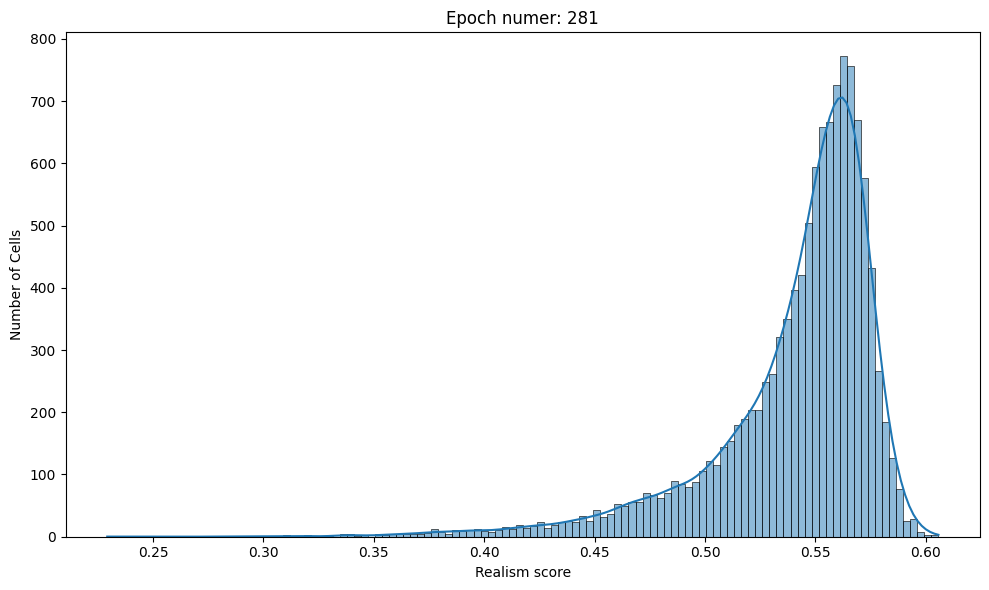

In [144]:
mean_rc = np.mean(rc)
median_rc = np.median(rc)
std_rc = np.std(rc)
plt.figure(figsize=(10, 6))
sns.histplot(rc, kde=True)
plt.xlabel("Realism score")
plt.ylabel("Number of Cells")
#plt.title("Epoch numer: "+str("281"))
plt.tight_layout()
plt.savefig(os.path.join(run_dir, 'Realism_score_distribution.png'), dpi=300)
plt.show()

In [15]:
# SEED
np.random.seed(42)

# AA class object
class NearestNeighborMetrics():
    """Calculate nearest neighbors and metrics"""

    def __init__(self, real_data, synths):
        self.data = {'train': real_data}

        # add all synthetics
        # for i, s in enumerate(synths):
        #self.data[f'synth_{i}'] = s.reshape(1,-1)
        #self.synth_keys = [f'synth_{i}' for i in range(len(synths))]
        self.data[f'synth_0'] = synths
        self.synth_keys = [f'synth_0']

        # pre allocate distances
        self.dists = {}

    def nearest_neighbors(self, t, s):
        """Find nearest neighbors d_ts and d_ss"""
        # fit to S
        nn_s = NearestNeighbors(n_neighbors=1).fit(self.data[s])
        if t == s:
            # find distances from s to s
            d = nn_s.kneighbors()[0]
        else:
            # find distances from t to s
            d = nn_s.kneighbors(self.data[t])[0]
        return t, s, d

    def compute_nn(self):
        """run all the nearest neighbors calculations"""
        tasks = product(self.data.keys(), repeat=2)

        with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
            futures = [
                executor.submit(self.nearest_neighbors, t, s)
                for (t, s) in tasks
            ]
            # wait for each job to finish
            for future in tqdm(
                    concurrent.futures.as_completed(futures),
                    total=len(futures)):
                t, s, d = future.result()
                self.dists[(t, s)] = d

    def divergence(self, t, s):
        """calculate the NN divergence"""
        left = np.mean(np.log(self.dists[(t, s)] / self.dists[(t, t)]))
        right = np.mean(np.log(self.dists[(s, t)] / self.dists[(s, s)]))
        return 0.5 * (left + right)

    def discrepancy_score(self, t, s):
        """calculate the NN discrepancy score"""
        left = np.mean(self.dists[(t, s)])
        right = np.mean(self.dists[(s, t)])
        return 0.5 * (left + right)

    def adversarial_accuracy(self, t, s):
        """calculate the NN adversarial accuracy"""
        left = np.mean(self.dists[(t, s)] > self.dists[(t, t)])
        right = np.mean(self.dists[(s, t)] > self.dists[(s, s)])
        return 0.5 * (left + right)

    def compute_discrepancy(self):
        """compute the standard discrepancy scores"""
        j_rr = self.discrepancy_score('train', 'train')
        j_ra = []
        j_aa = []
        # for all of the synthetic datasets
        for k in self.synth_keys:
            j_ra.append(self.discrepancy_score('train', k))
            # comparison to other synthetics
            for k_2 in self.synth_keys:
                if k != k_2:
                    j_aa.append(self.discrepancy_score(k, k_2))

        # average accross synthetics
        j_ra = np.mean(np.array(j_ra))
        j_aa = np.mean(np.array(j_aa))
        return j_rr, j_ra, j_aa

    def compute_divergence(self):
        """compute the standard divergence scores"""
        d_tr_a = []
        for k in self.synth_keys:
            d_tr_a.append(self.divergence('train', k))

        training = np.mean(np.array(d_tr_a))
        return training

    def compute_adversarial_accuracy(self):
        """compute the standarad adversarial accuracy scores"""
        a_tr_a = []
        for k in self.synth_keys:
            a_tr_a.append(self.adversarial_accuracy('train', k))

        a_tr = np.mean(np.array(a_tr_a))
        return a_tr

# Compute metric


def compute_AAts(real_data: np.array = None, fake_data: np.array = None):
    """ Compute similarity scores based on nearest neighbors distances.
    ----
    Parameters:
        real_data (np.array): array of real data
        fake_data (np.array): array of synthetic data
    Returns:
        discrepancy score, divergence score, adversarial accuracy
    """
    nnm = NearestNeighborMetrics(real_data, fake_data)
    nnm.compute_nn()

    # run discrepancy score, divergence, adversarial accuracy
    discrepancy = nnm.compute_discrepancy()
    #divergence = nnm.compute_divergence()
    adversarial = nnm.compute_adversarial_accuracy()

    return discrepancy[0], discrepancy[1], adversarial

In [145]:
AAts = compute_AAts(df_real, df_gen)

100%|██████████| 4/4 [01:18<00:00, 19.63s/it]
/Users/guyshani/Documents/PHD/Aim_2/cycle_GAN/.venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/guyshani/Documents/PHD/Aim_2/cycle_GAN/.venv/lib/python3.11/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [146]:
print("Nearest Neighbour Adversarial Accuracy: "+str(AAts))

Nearest Neighbour Adversarial Accuracy: (np.float64(252.50515953541526), np.float64(510.9034779192888), np.float64(1.0))


In [147]:
with open(run_dir+"misc_metrics.txt", 'w') as file:
    file.write("Gamma coefficient: "+str(g[0])+"\n")
    file.write("Mean realism score: "+str(mean_rc)+"\n")
    file.write("Median realism score: "+str(median_rc)+"\n")
    file.write("STD realism score: "+str(std_rc)+"\n")
    file.write("Precision-Recall: "+str(pr)+"\n")
    file.write("Nearest Neighbour Adversarial Accuracy: "+str(AAts))

In [ ]:
################################# Project generated cells on real celss UMAP

In [148]:
# Load files
generated_h5ad = os.path.join(run_dir, "generated_data.h5ad")  # The newly generated h5ad file
real_h5ad = os.path.join(data_path, "test_data_library_counts_PBMC.h5ad")  # The original h5ad file
adataGen = ad.read_h5ad(generated_h5ad)
adataReal = ad.read_h5ad(real_h5ad)

Computing PCA for real data...
Real data PCA computed.
Computing PCA for generated data...
Generated data PCA computed.
Computing UMAP transformation...


/Users/guyshani/Documents/PHD/Aim_2/cycle_GAN/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/guyshani/Documents/PHD/Aim_2/cycle_GAN/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/guyshani/Documents/PHD/Aim_2/cycle_GAN/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/guyshani/Documents/PHD/Aim_2/cycle_GAN/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


UMAP transformation complete.


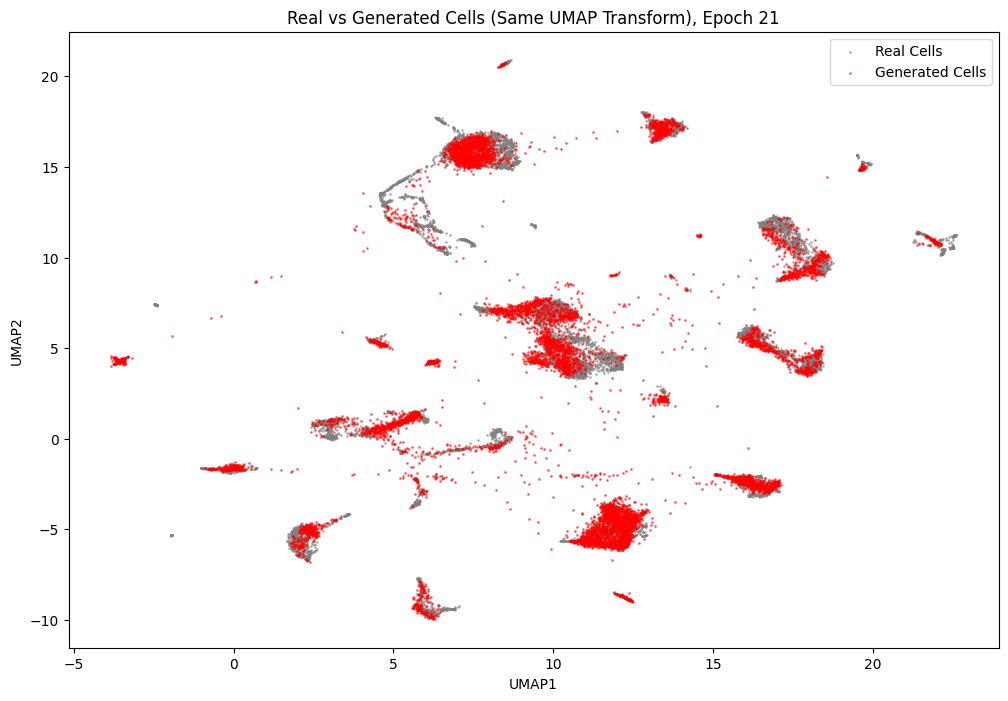

In [149]:
# Compute PCA if not already present
n_pcs = 50  # Number of principal components to use

# Perform PCA on real data if not already done
#if 'X_pca' not in adataReal.obsm:
print("Computing PCA for real data...")
sc.pp.scale(adataReal, max_value=10)
sc.tl.pca(adataReal, n_comps=n_pcs)
print("Real data PCA computed.")

# Perform PCA on generated data using the same PCA model from real data
print("Computing PCA for generated data...")
# First, we need to scale the generated data
sc.pp.scale(adataGen, max_value=10)

# Use the PCA model from real data to transform the generated data
pca = adataReal.uns['pca']['variance_ratio']
pca_components = adataReal.varm['PCs']
# Project generated data onto the PCA space of real data
gen_pca = np.dot(adataGen.X, pca_components)
adataGen.obsm['X_pca'] = gen_pca
print("Generated data PCA computed.")

# Create a UMAP transformer with default parameters and fit on real data
print("Computing UMAP transformation...")
transformer = umap.UMAP(
    n_neighbors=15,  # default parameters
    min_dist=0.1,
    spread=1.0,
    random_state=42
).fit(adataReal.obsm['X_pca'])

# Transform both datasets using this same transformer
real_umap = transformer.transform(adataReal.obsm['X_pca'])
gen_umap = transformer.transform(adataGen.obsm['X_pca'])
print("UMAP transformation complete.")

# Plot them together
plt.figure(figsize=(12, 8))
plt.scatter(real_umap[:, 0],
           real_umap[:, 1],
           c='gray',
           alpha=0.5,
           s=1,
           label='Real Cells')
plt.scatter(gen_umap[:, 0],
           gen_umap[:, 1],
           c='red',
           alpha=0.5,
           s=1,
           label='Generated Cells')
plt.title('Real vs Generated Cells (Same UMAP Transform), Epoch 21')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend()
plt.savefig(os.path.join(run_dir, 'umap_real_vs_generated.png'), dpi=300)
plt.show()